# Spaceship Titanic

- 세번째 시도
    - Tensorflow 모듈을 사용한 의사결정트리 사용

## Import Modules

In [1]:
import os
from datetime import datetime
from zipfile import ZipFile
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import tensorflow as tf
import tensorflow_decision_forests as tfdf

2023-12-12 07:12:30.329653: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-12 07:12:30.360053: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-12 07:12:30.360077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-12 07:12:30.360709: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-12 07:12:30.365127: I tensorflow/core/platform/cpu_feature_guar

## Set envs

In [2]:
PATH_INPUT = './data/in/'
PATH_OUTPUT = './data/out/'
NOW_STR = datetime.now().strftime('%Y%m%d_%H%M%S')
PATH_OUTPUT_NOW = f'./data/out/{NOW_STR}/'

config = tf.

## Check Data

### Get Data

In [3]:
with ZipFile(PATH_INPUT + 'spaceship-titanic.zip') as f:
    print(f.namelist())

    df_train = pd.read_csv(BytesIO(f.read('train.csv')))
    df_test = pd.read_csv(BytesIO(f.read('test.csv')))
    df_sample = pd.read_csv(BytesIO(f.read('sample_submission.csv')))

['sample_submission.csv', 'test.csv', 'train.csv']


### Print Data

In [4]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [6]:
df_sample.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


## Data Preprocessing

In [7]:
df_train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


### Delete Null Data

In [9]:
df_train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

- HomePlanet,CryoSleep,Cabin,Destination,VIP: null -> delete

In [10]:
df_train.dropna(subset=['HomePlanet','CryoSleep','Cabin','Destination','VIP'], inplace=True)

- Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck: null -> most frequency

In [11]:
columns = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
for col in columns:
    most_freq = df_train[col].mode()[0]
    df_train[col].fillna(value=most_freq, inplace=True)

In [12]:
df_train.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin             0
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            177
Transported       0
dtype: int64

### Data Bias

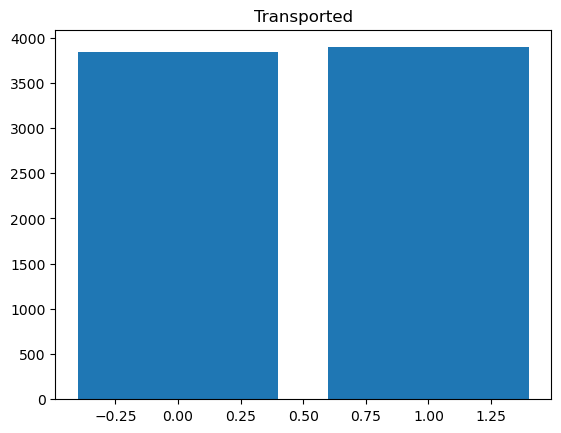

In [13]:
x = df_train['Transported'].unique()
y = [ len(df_train[df_train['Transported'] == i]) for i in x ]
plt.title('Transported')
plt.bar(x,y)
plt.show()

/home/momo/anaconda3/envs/tfgpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/momo/anaconda3/envs/tfgpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/momo/anaconda3/envs/tfgpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/momo/anaconda3/envs/tfgpu/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

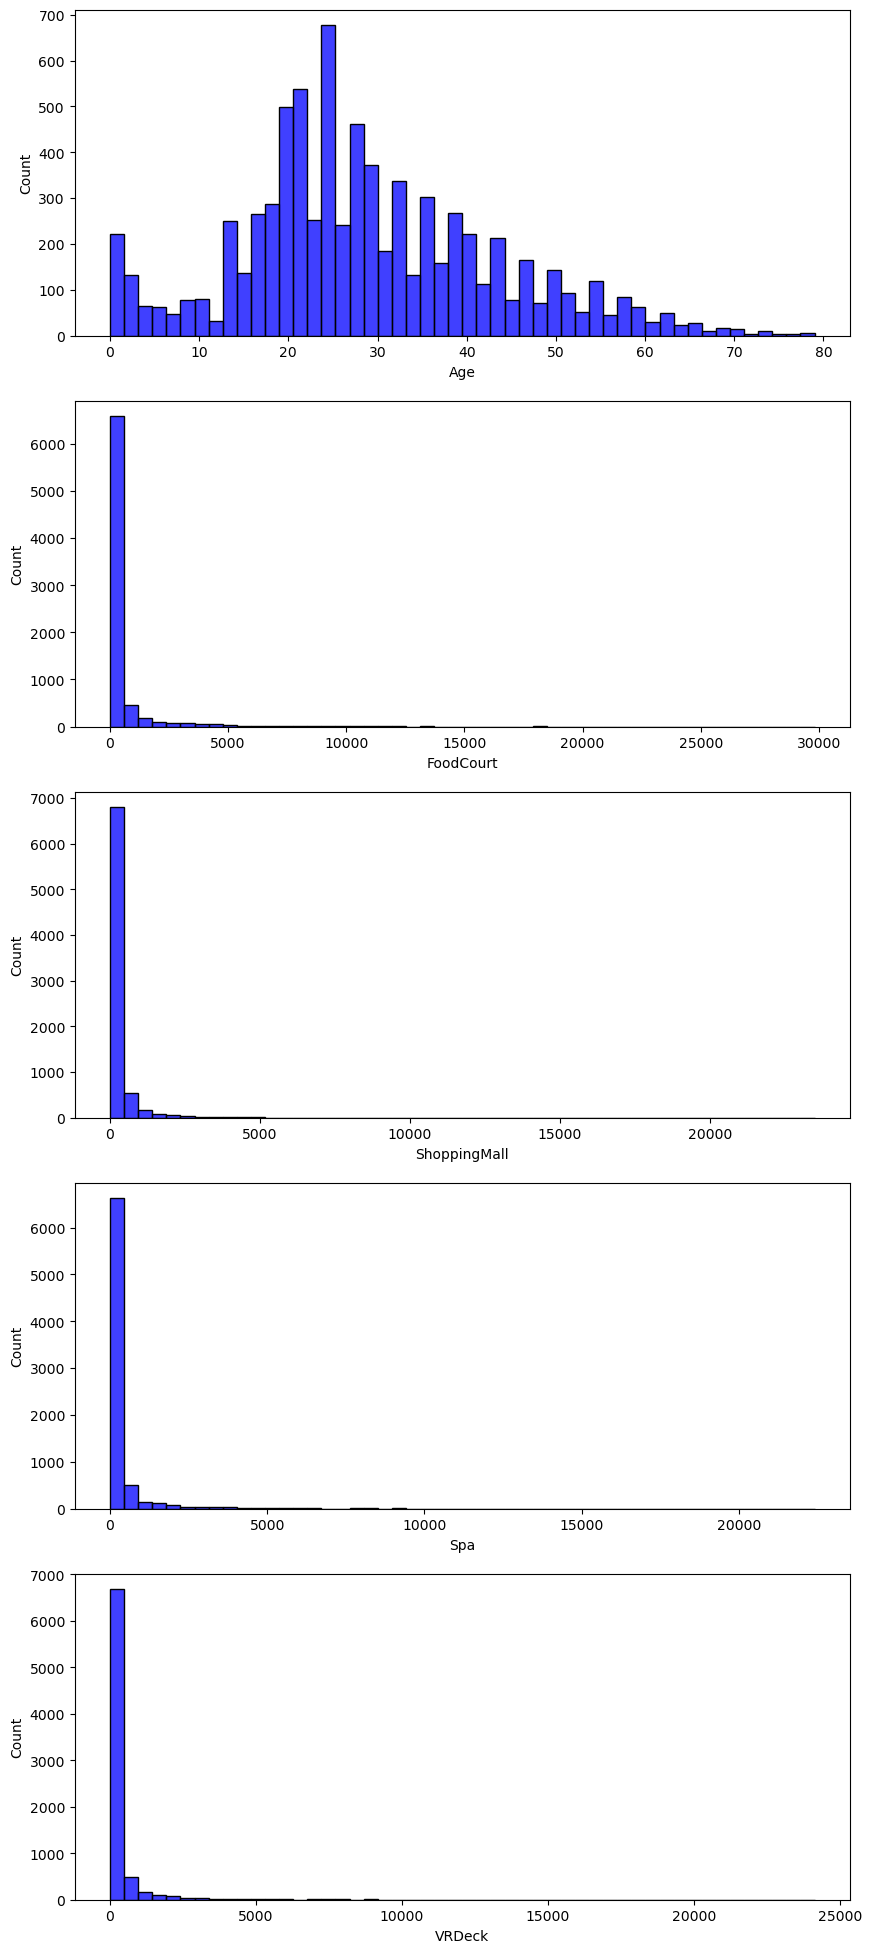

In [14]:
fig, ax = plt.subplots(5,1,  figsize=(10, 10))
plt.subplots_adjust(top = 2)

sns.histplot(df_train['Age'], color='b', bins=50, ax=ax[0]);
sns.histplot(df_train['FoodCourt'], color='b', bins=50, ax=ax[1]);
sns.histplot(df_train['ShoppingMall'], color='b', bins=50, ax=ax[2]);
sns.histplot(df_train['Spa'], color='b', bins=50, ax=ax[3]);
sns.histplot(df_train['VRDeck'], color='b', bins=50, ax=ax[4]);

### String Data

In [15]:
non_num = ['HomePlanet', 'Cabin', 'Destination']
for col in non_num:
    uniq = df_train[col].unique()
    print("{0:=^40}".format(col))
    print(f'{uniq}  ({len(uniq)})')

===============HomePlanet===============
['Europa' 'Earth' 'Mars']  (3)
=================Cabin==================
['B/0/P' 'F/0/S' 'A/0/S' ... 'G/1499/S' 'G/1500/S' 'E/608/S']  (6068)
==============Destination===============
['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e']  (3)


-> HomePlanet, Destination : One-hot Encoding

In [16]:
df_train = pd.get_dummies(df_train, columns=['HomePlanet', 'Destination'], dtype=int)

-> CryoSleep, VIP, Transported: Label Encoding (True: 1, False: 0)

In [17]:
df_train["CryoSleep"] = df_train["CryoSleep"].astype(int)
df_train["VIP"] = df_train["VIP"].astype(int)
df_train["Transported"] = df_train["Transported"].astype(int)

-> Cabin: split to "Deck", "Cabin_num", "Side"

In [18]:
df_train[["Deck", "Cabin_num", "Side"]] = df_train["Cabin"].str.split("/", expand=True)
df_train.drop("Cabin", axis=1, inplace=True)

In [19]:
df_train

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck,Cabin_num,Side
0,0001_01,0,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,0,1,0,0,0,1,B,0,P
1,0002_01,0,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,1,0,0,0,0,1,F,0,S
2,0003_01,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,1,0,0,0,1,A,0,S
3,0003_02,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,1,0,0,0,1,A,0,S
4,0004_01,0,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,1,0,0,0,0,1,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,0,1,0,1,0,0,A,98,P
8689,9278_01,1,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,1,0,0,0,1,0,G,1499,S
8690,9279_01,0,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,1,0,0,0,0,1,G,1500,S
8691,9280_01,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,0,1,0,1,0,0,E,608,S


## Train

### Set Input data

In [20]:
exception_cols = ['PassengerId', 'Name']
dependants = ['Transported']
independents = [ i for i in df_train.keys() if i not in dependants and i not in exception_cols ]
# 'CryoSleep', 'Cabin', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e'

X = df_train[independents]
Y = df_train[dependants]

X_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(df_train, label="Transported")

2023-12-12 07:12:32.682101: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-12 07:12:32.738991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-12 07:12:32.739059: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-12 07:12:32.742456: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-12 07:12:32.742551: I external/local_xla/xla/stream_executor

In [21]:
X.shape, Y.shape

((7736, 17), (7736, 1))

### Check available all models

In [22]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

### 1. Use RandomForestModel

#### Build Model

In [23]:
model = tfdf.keras.RandomForestModel(verbose=1)
model.compile(
    metrics=['accuracy']
)

Use /tmp/tmpo2v_4r0d as temporary training directory


#### Fit Model

In [27]:
with tf.device("/device:GPU:0"):
    model.fit(X_tf_dataset)

Reading training dataset...
Training dataset read in 0:00:00.070468. Found 7736 examples.
Training model...


[INFO 23-12-12 07:13:15.5355 KST kernel.cc:1233] Loading model from path /tmp/tmpo2v_4r0d/model/ with prefix 91668068677843c6


Model trained in 0:00:07.358901
Compiling model...
Model compiled.


[INFO 23-12-12 07:13:15.8185 KST decision_forest.cc:660] Model loaded with 300 root(s), 257128 node(s), and 17 input feature(s).
[INFO 23-12-12 07:13:15.8185 KST abstract_model.cc:1344] Engine "RandomForestGeneric" built
[INFO 23-12-12 07:13:15.8186 KST kernel.cc:1061] Use fast generic engine


#### Visualize Model

In [25]:
tfdf.model_plotter.plot_model(model, tree_idx=0, max_depth=3)

'\n<script src="https://d3js.org/d3.v6.min.js"></script>\n<div id="tree_plot_cf2690faaf82453da8e99403ca06b542"></div>\n<script>\n/*\n * Copyright 2021 Google LLC.\n * Licensed under the Apache License, Version 2.0 (the "License");\n * you may not use this file except in compliance with the License.\n * You may obtain a copy of the License at\n *\n *     https://www.apache.org/licenses/LICENSE-2.0\n *\n * Unless required by applicable law or agreed to in writing, software\n * distributed under the License is distributed on an "AS IS" BASIS,\n * WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.\n * See the License for the specific language governing permissions and\n * limitations under the License.\n */\n\n/**\n *  Plotting of decision trees generated by TF-DF.\n *\n *  A tree is a recursive structure of node objects.\n *  A node contains one or more of the following components:\n *\n *    - A value: Representing the output of the node. If the node is not a leaf,\

In [26]:
# tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8147084246006629936
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9816768512
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15742576899957851814
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2023-12-12 07:12:44.695625: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-12 07:12:44.695765: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-12 07:12:44.695795: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-12 07:12:44.696117: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-12 07:12:44.696132: I tensorflow/core/common_runtime/gpu/gpu